In [2]:
import re
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import os

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tools import add_constant
import statsmodels.formula.api as smf
from sklearn.utils import resample
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import xgboost as xgb
from scipy.stats import pearsonr, ttest_ind, mannwhitneyu, wilcoxon, ranksums, kruskal, zscore
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression, LassoCV, RidgeCV
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
# Завантаження даних
file_name = "ikea.csv"
file_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv"

if not os.path.exists(file_name):
    print(f"File '{file_name}' not found. Loading...")
    response = requests.get(file_url)

    if response.status_code == 200:
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"File '{file_name}' success download.")
    else:
        print(f"Error {response.status_code}")
        exit()
else:
    print(f"File '{file_name}' already exists.").status_code == 200

File 'ikea.csv' not found. Loading...
File 'ikea.csv' success download.


### 1. Дослідницький аналіз даних (EDA)

In [4]:
data = pd.read_table(file_url, delimiter=',')
print("Розмір датасету")
data.shape

Розмір датасету


(3694, 14)

In [5]:
print("Iнформація про датасет")
data.info()

Iнформація про датасет
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


>**item_id** - unique number for item. Type: int64  
> **name** - name of item. Type: int64  
> **category** - category name.  Type: int64  
> **price** - price of item.  Type: float64     
> **old_price** - have or not old_price. Type: object   
> **sellable_online** - item in online market. Type: bool   
> **link** - link on item in market. Type: object   
> **other_colors** - available or not different color of item. Type: object   
> **short_description** - short info about item . Type: object   
> **designer** - designer name. Type: object    
> **depth**   - depth of item. Type: float64  
> **height** - height of item. Type: float64  
> **width**  - width of item. Type:  float64  

In [6]:
# вивід перших 5 записів
print(data.head(5).to_markdown(index=False))

|   Unnamed: 0 |   item_id | name                  | category      |   price | old_price    | sellable_online   | link                                                                                               | other_colors   | short_description                               | designer             |   depth |   height |   width |
|-------------:|----------:|:----------------------|:--------------|--------:|:-------------|:------------------|:---------------------------------------------------------------------------------------------------|:---------------|:------------------------------------------------|:---------------------|--------:|---------:|--------:|
|            0 |  90420332 | FREKVENS              | Bar furniture |     265 | No old price | True              | https://www.ikea.com/sa/en/p/frekvens-bar-table-in-outdoor-black-90420332/                         | No             | Bar table, in/outdoor,          51x51 cm        | Nicholai Wiig Hansen |     nan |       99 |   

In [7]:
# вивід 5 рандомних записів
print(data.sample(5).to_markdown(index=False))

|   Unnamed: 0 |   item_id | name            | category             |   price | old_price    | sellable_online   | link                                                                                     | other_colors   | short_description                                  | designer                       |   depth |   height |   width |
|-------------:|----------:|:----------------|:---------------------|--------:|:-------------|:------------------|:-----------------------------------------------------------------------------------------|:---------------|:---------------------------------------------------|:-------------------------------|--------:|---------:|--------:|
|         3574 |  89227873 | PAX             | Wardrobes            |    1499 | No old price | True              | https://www.ikea.com/sa/en/p/pax-wardrobe-white-s89227873/                               | Yes            | Wardrobe,          150x58x201 cm                   | Ehlén Johansson/IKEA of Sweden |      58 |  

In [8]:
# видаляємо колонку 'Unnamed: 0'
data = data.drop(['Unnamed: 0'], axis = 1)
print(data.head(5).to_markdown(index=False))

|   item_id | name                  | category      |   price | old_price    | sellable_online   | link                                                                                               | other_colors   | short_description                               | designer             |   depth |   height |   width |
|----------:|:----------------------|:--------------|--------:|:-------------|:------------------|:---------------------------------------------------------------------------------------------------|:---------------|:------------------------------------------------|:---------------------|--------:|---------:|--------:|
|  90420332 | FREKVENS              | Bar furniture |     265 | No old price | True              | https://www.ikea.com/sa/en/p/frekvens-bar-table-in-outdoor-black-90420332/                         | No             | Bar table, in/outdoor,          51x51 cm        | Nicholai Wiig Hansen |     nan |       99 |      51 |
|    368814 | NORDVIKEN             |

In [9]:
print("Статистика по числовим ознакам")
display(data.describe())

Статистика по числовим ознакам


,item_id,price,depth,height,width
count,3.694000e+03,3694.000000,2231.000000,2706.000000,3105.000000
mean,4.863240e+07,1078.208419,54.379202,101.679970,104.470853
std,2.888709e+07,1374.652494,29.958351,61.097585,71.133771
min,5.848700e+04,3.000000,1.000000,1.000000,1.000000
25%,2.039057e+07,180.900000,38.000000,67.000000,60.000000
50%,4.928808e+07,544.700000,47.000000,83.000000,80.000000
75%,7.040357e+07,1429.500000,60.000000,124.000000,140.000000
max,9.993262e+07,9585.000000,257.000000,700.000000,420.000000


In [10]:
print("Кількість пропущених значень")
display(data.isnull().sum())

Кількість пропущених значень


,0
item_id,0
name,0
category,0
price,0
old_price,0
sellable_online,0
link,0
other_colors,0
short_description,0
designer,0


In [11]:
# Визначаємо, в яких категоріях є пропущені значення
nan_count = data[['depth', 'height', 'width']].isna().groupby(data['category']).sum()

# Сортуємо по стовпцю 'depth'
print(nan_count.sort_values(by='depth', ascending=False))

                                      depth  height  width
category                                                  
Tables & desks                          483     199    113
Chairs                                  203     191     92
Sofas & armchairs                       197     145    155
Beds                                    125      51     23
Outdoor furniture                       112      85     48
Bookcases & shelving units               95     106     56
TV & media furniture                     57      62     36
Cabinets & cupboards                     55      62     36
Nursery furniture                        31      13      4
Children's furniture                     30      26      6
Bar furniture                            20      12     10
Trolleys                                 19       1      0
Wardrobes                                14      24      4
Café furniture                           12       4      5
Chests of drawers & drawer units          4       2     

In [12]:
# Скільки разів кожен item_id зустрічається
duplicate_counts = data['item_id'].value_counts()

# Фільтруємо item_id, що мають дублікати
duplicate_counts = duplicate_counts[duplicate_counts > 1]

top_dublicates = duplicate_counts.head(10).reset_index()
top_dublicates.head(10)

,item_id,count
0,79241940,4
1,29297227,3
2,19297275,3
3,60400745,3
4,70370352,3
5,295530,3
6,60323592,3
7,397736,3
8,10281354,3
9,20330599,3


In [13]:
# Переглянемо дублікати
duplicates_by_item_id = data[data.duplicated(subset=['item_id'], keep=False)]
duplicates_by_item_id_sorted = duplicates_by_item_id.sort_values(by=['item_id']).reset_index(drop=True)[['item_id', 'price', 'designer', 'category']]
print(duplicates_by_item_id_sorted.head(20).to_markdown(index=False))

|   item_id |   price | designer                        | category                             |
|----------:|--------:|:--------------------------------|:-------------------------------------|
|     91415 |       5 | Studio Copenhagen               | Nursery furniture                    |
|     91415 |       5 | Studio Copenhagen               | Children's furniture                 |
|    102065 |     495 | IKEA of Sweden                  | Sofas & armchairs                    |
|    102065 |     495 | IKEA of Sweden                  | Beds                                 |
|    105064 |     445 | Carina Bengs                    | Sideboards, buffets & console tables |
|    105064 |     445 | Carina Bengs                    | Tables & desks                       |
|    121766 |     395 | Carina Bengs                    | Chairs                               |
|    121766 |     395 | Carina Bengs                    | Bar furniture                        |
|    165213 |     225 | Carl Ö

Тобто, дублікати мають однакову ціну, дизайнера та відрізняються лише належністю до різних каатегорій

In [14]:
# Видалимо дублікати по 'item_id', залишаємо перший рядок:
data_unique = data.drop_duplicates(subset=['item_id'], keep='first').copy()
print("Розмір датасету після видалення дублікатів:", data_unique.shape)

Розмір датасету після видалення дублікатів: (2962, 13)


In [15]:
# Конвертація sellable_online у булевий тип
data_unique['sellable_online'] = data_unique['sellable_online'].astype(bool)

# Заміна 'Yes' -> 1, 'No' -> 0 у other_colors
data_unique['other_colors'] = data_unique['other_colors'].replace({'Yes': 1, 'No': 0})
data_unique = data_unique.infer_objects(copy=False)

print(data_unique.head(5).to_markdown(index=False))

|   item_id | name                  | category      |   price | old_price    | sellable_online   | link                                                                                               |   other_colors | short_description                               | designer             |   depth |   height |   width |
|----------:|:----------------------|:--------------|--------:|:-------------|:------------------|:---------------------------------------------------------------------------------------------------|---------------:|:------------------------------------------------|:---------------------|--------:|---------:|--------:|
|  90420332 | FREKVENS              | Bar furniture |     265 | No old price | True              | https://www.ikea.com/sa/en/p/frekvens-bar-table-in-outdoor-black-90420332/                         |              0 | Bar table, in/outdoor,          51x51 cm        | Nicholai Wiig Hansen |     nan |       99 |      51 |
|    368814 | NORDVIKEN             |

<ipython-input-15-fd639a7d2b7a>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_unique['other_colors'] = data_unique['other_colors'].replace({'Yes': 1, 'No': 0})


In [16]:
# очистка колонки 'designer'
def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
    if not isinstance(value, str):
        return value
    if len(value) > 0 and value[0].isdigit():
        return emptyValue
    designers = value.split("/")
    if removeIKEA:
        try:
            designers.remove("IKEA of Sweden")
        except:
            pass
    if len(designers) > 0:
        return '/'.join(sorted(designers))
    else:
        return emptyValue

data_unique['designer_clean'] = data_unique['designer'].apply(cleanDesigners, args= (False, "IKEA of Sweden"))

print('Кількість товарів по кожному дизайнеру')
display(data_unique['designer_clean'].value_counts())

Кількість товарів по кожному дизайнеру


,count
designer_clean,
IKEA of Sweden,785
Ehlén Johansson/IKEA of Sweden,138
Ehlén Johansson,136
Francis Cayouette,131
Ola Wihlborg,128
...,...
Gustav Carlberg/IKEA of Sweden/Johanna Asshoff,1
Chris Martin/IKEA of Sweden,1
J Karlsson/W Chong,1


In [17]:
# очистка колонки 'old_price'
def clean_old_price(value):
    if value == "No old price" or pd.isna(value):
        return np.nan
    value = str(value).replace('SR', '').replace(',', '').strip()
    try:
        return float(value)
    except ValueError:
        return np.nan

data_unique['old_price_clean'] = data_unique['old_price'].apply(clean_old_price)
data_unique['old_price_clean'].value_counts()

,count
old_price_clean,
595.0,10
995.0,7
275.0,7
400.0,6
1495.0,6
...,...
3665.0,1
2350.0,1
2495.0,1


In [18]:
# Додавання стовпця розміру
data_unique['size'] = data_unique['height'] * data_unique['width'] * data_unique['depth']

In [19]:
# Перевіряємо розмір датасету з урахуванням змін
data_unique.shape

(2962, 16)

In [20]:
unique_count = data_unique['link'].nunique()
total_count = len(data_unique)
print(f"Унікальних лінків: {unique_count} із {total_count}")

Унікальних лінків: 2962 із 2962


### 2. Побудова візуалізацій

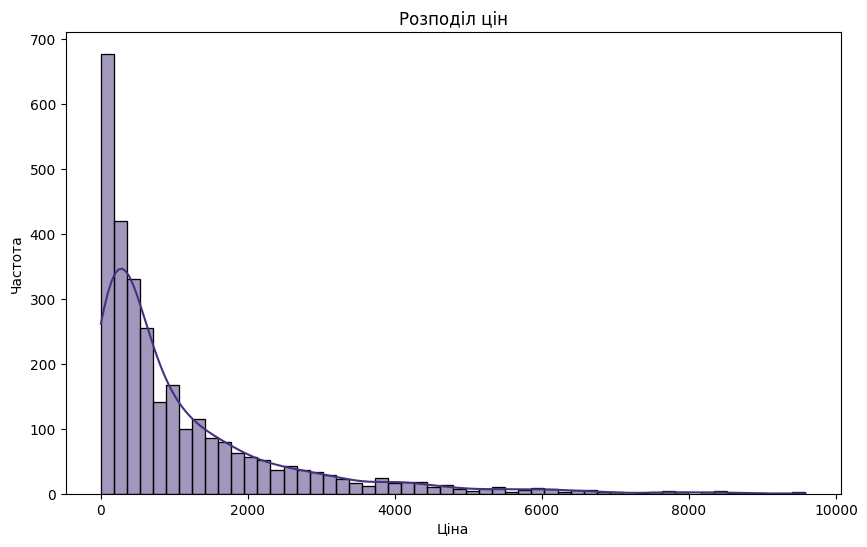

In [21]:
# Розмір для всіх графіків
plt.rcParams["figure.figsize"] = (10, 6)
# Палітра кольорів для всіх графіків
sns.set_palette("viridis")

sns.histplot(data_unique['price'], kde=True)
plt.title('Розподіл цін')
plt.xlabel('Ціна')
plt.ylabel('Частота')
plt.show()

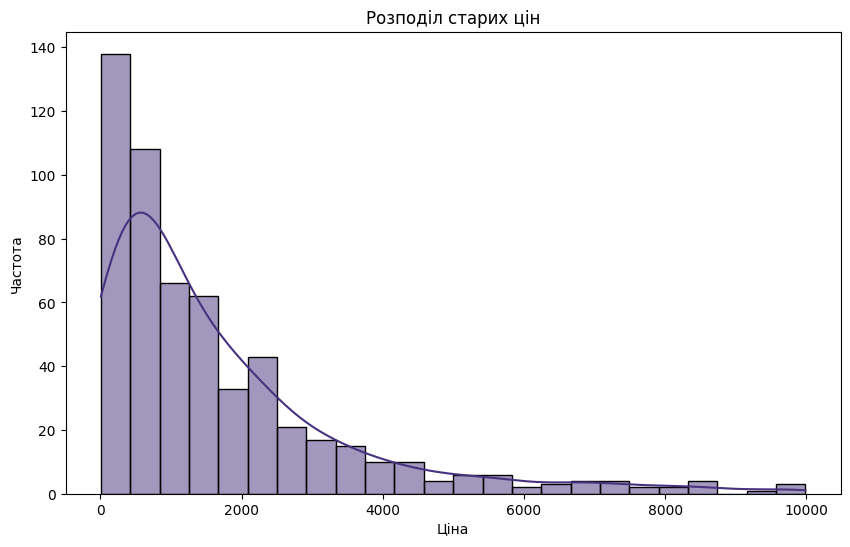

In [22]:
sns.histplot(data_unique['old_price_clean'], kde=True)
plt.title('Розподіл старих цін')
plt.xlabel('Ціна')
plt.ylabel('Частота')
plt.show()

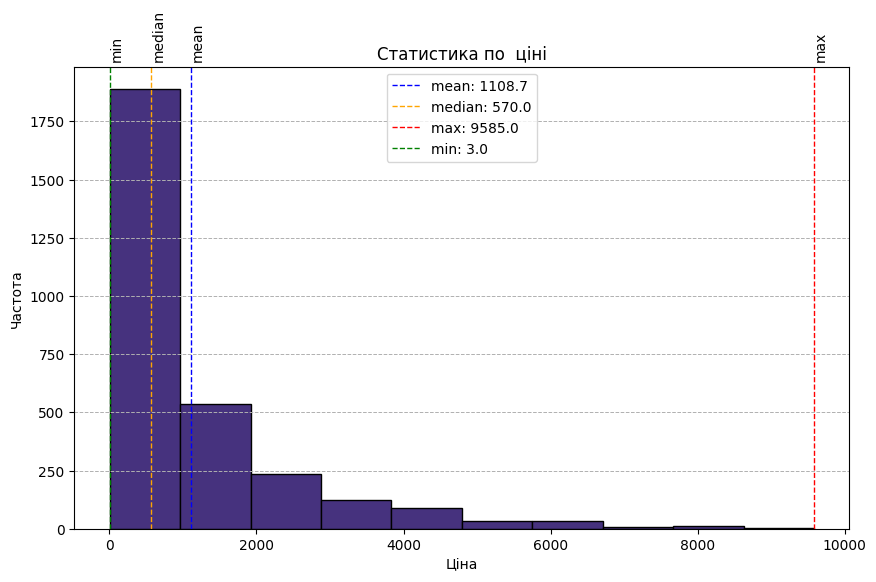

In [23]:
# Детальніше розглянемо ціну (макс, мін, ср, медіана)
price = data_unique["price"]
mean = price.mean()
median = price.median()
max_price = price.max()
min_price = price.min()

plt.hist(price, edgecolor='black')
plt.title("Статистика по  ціні")
plt.xlabel("Ціна")
plt.ylabel("Частота")

for value, color, label in [(mean, 'blue', 'mean'), (median, 'orange', 'median'), (max_price, 'red', 'max'), (min_price, 'green', 'min')]:
    plt.axvline(value, color=color, linestyle='dashed', linewidth=1, label=f"{label}: {value:.1f}")
    plt.text(value, 2020, label, rotation=90, va="baseline")

plt.grid(axis='y', linestyle = '--', linewidth = 0.7)
plt.legend()
plt.show()

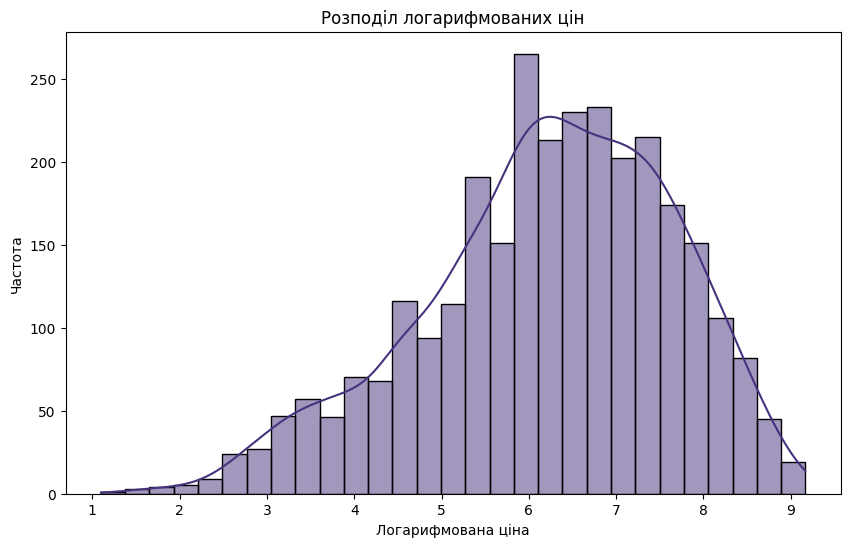

In [24]:
# Логарифмування ціни для нормалізації розподілу
data_unique['price_ln'] = np.log(data_unique['price'])
sns.histplot(data_unique['price_ln'], kde=True)
plt.title('Розподіл логарифмованих цін')
plt.xlabel('Логарифмована ціна')
plt.ylabel('Частота')
plt.show()

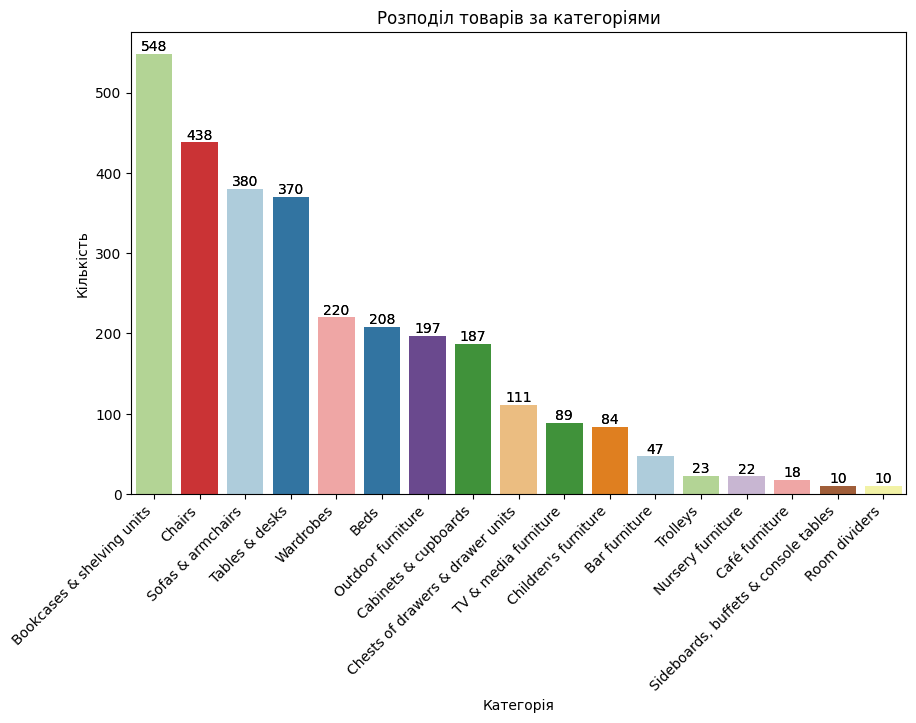

In [25]:
# Сортування категорій за кількістю товарів від найпопулярнішої до менш популярної
category_counts = data_unique['category'].value_counts().index

# Побудова countplot з сортуванням
ax = sns.countplot(x='category', data=data_unique, hue='category', palette='Paired', order=category_counts)
sns.countplot(x='category', data=data_unique, hue='category', palette='Paired', order=category_counts)
plt.title('Розподіл товарів за категоріями')
plt.xlabel('Категорія')
plt.ylabel('Кількість')
plt.xticks(rotation=45, ha='right')

# Додавання підписів з кількістю товарів над стовпчиками
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

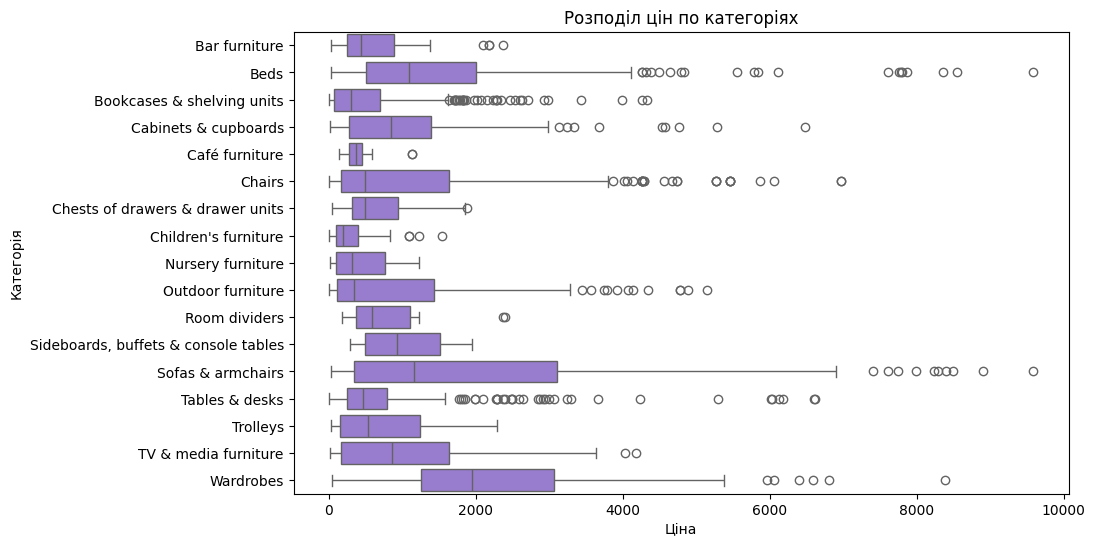

In [26]:
sns.boxplot(data=data_unique, x='price', y='category', color='#9370DB')
plt.title('Розподіл цін по категоріях')
plt.xlabel('Ціна')
plt.ylabel('Категорія')
plt.show()

На даному графіку багато чорних точок (викидів), бо розподіл ціни має довгий хвіст вправо (є значно дорожчі товарів).

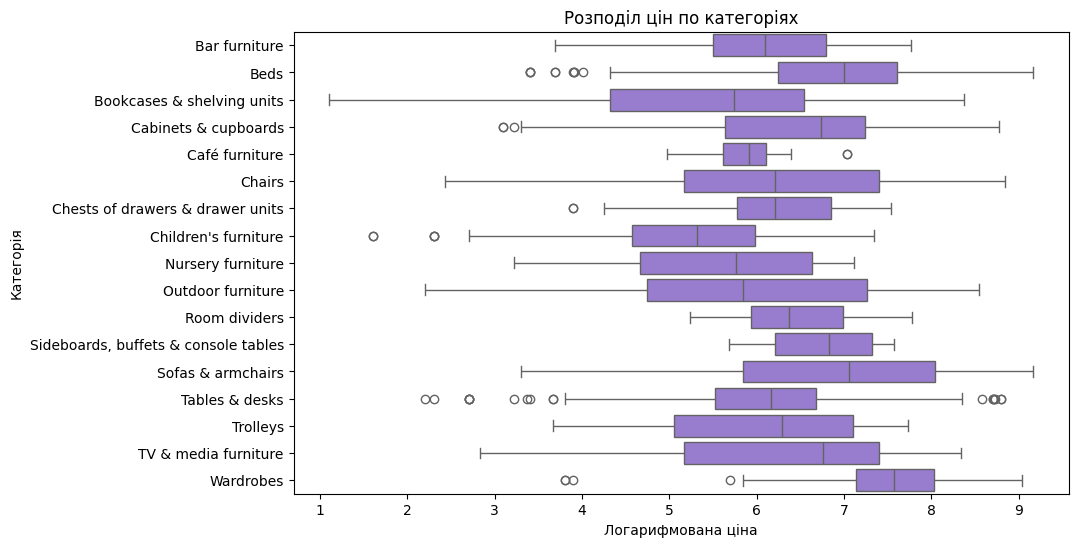

In [27]:
# Побудова графіку для логарифмованої ціни
sns.boxplot(data=data_unique, x='price_ln', y='category', color='#9370DB')
plt.title('Розподіл цін по категоріях')
plt.xlabel('Логарифмована ціна')
plt.ylabel('Категорія')
plt.show()

Логарифмована ціна дозволяє чіткіше побачити відмінності між категоріями меблів, згладжує вплив найдорожчих товарів і покращує інтерпретацію розподілу. Найдорожчі категорії (найвищі медіани логарифмованої ціни): барні меблі, ліжка,
шафи.
Найдешевші категорії (найнижчі медіани): тумби на колесах (Trolleys), меблі для дітей.
Розкид цін у категоріях значно відрізняється.
Ліжка, шафи та барні меблі мають великий діапазон цін, що може свідчити про наявність як бюджетних, так і преміальних моделей.
Меблі для кафе, дитячі меблі та тумби мають більш компактний розподіл, що означає менш виражену різницю між найдешевшими та найдорожчими моделями.

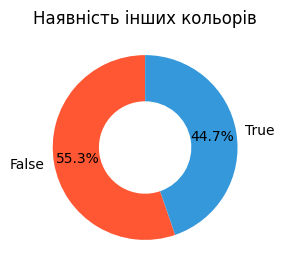

In [28]:
data_unique['other_colors_1'] = data_unique['other_colors'].astype(str)
other_colors_counts = data_unique['other_colors_1'].value_counts()
labels = other_colors_counts.index.map({'1': 'True', '0': 'False'})
sizes = other_colors_counts.values
colors = ['#FF5733', '#3498DB']

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, wedgeprops=dict(width=0.5), startangle=90, autopct='%1.1f%%', pctdistance=0.74, colors=colors)

for text in autotexts:
    text.set_fontsize(10)

ax.set_title("Наявність інших кольорів")
plt.show()

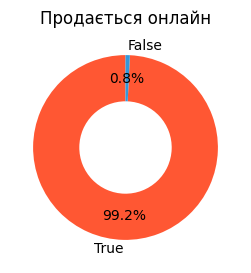

In [29]:
sellable_online_counts = data['sellable_online'].value_counts(normalize=True) * 100
labels = sellable_online_counts.index.astype(str)
sizes = sellable_online_counts.values
colors = ['#FF5733', '#3498DB']

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, wedgeprops=dict(width=0.5), startangle=90, autopct='%1.1f%%', pctdistance=0.74, colors=colors)

for text in autotexts:
    text.set_fontsize(10)

ax.set_title("Продається онлайн")
plt.show()

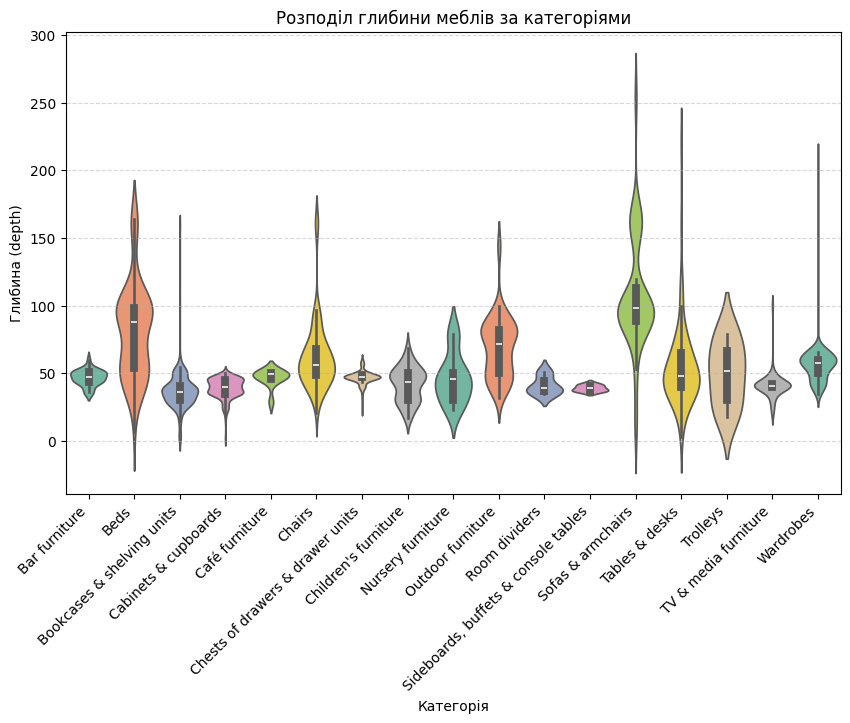

In [30]:
sns.violinplot(data=data_unique, x='category', y='depth', hue='category', palette="Set2", legend=False)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel("Категорія")
plt.ylabel("Глибина (depth)")
plt.title("Розподіл глибини меблів за категоріями")
plt.show()

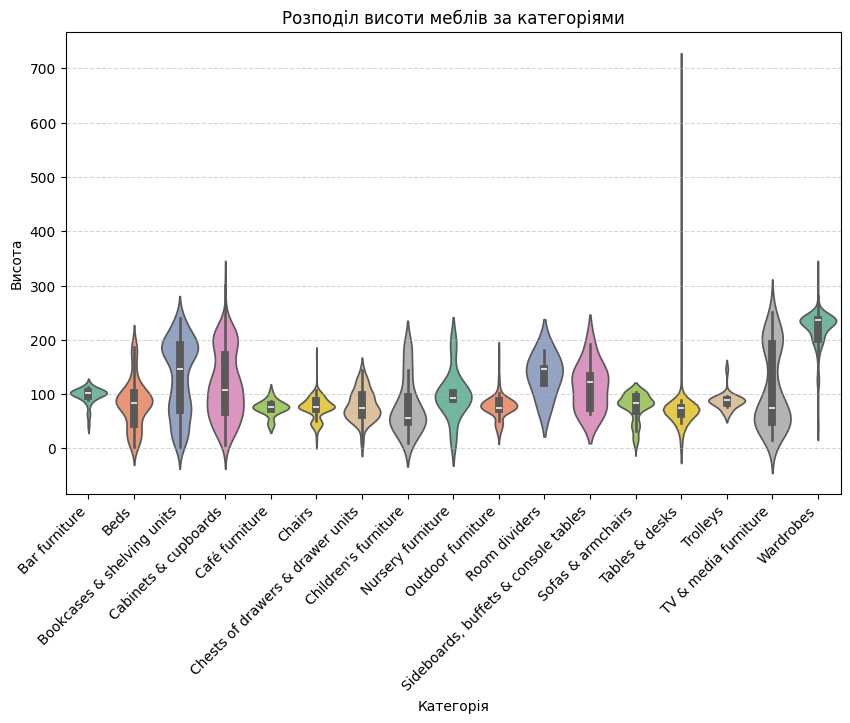

In [31]:
sns.violinplot(data=data_unique, x='category', y='height', hue='category', palette="Set2", legend=False)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel("Категорія")
plt.ylabel("Висота")
plt.title("Розподіл висоти меблів за категоріями")
plt.show()

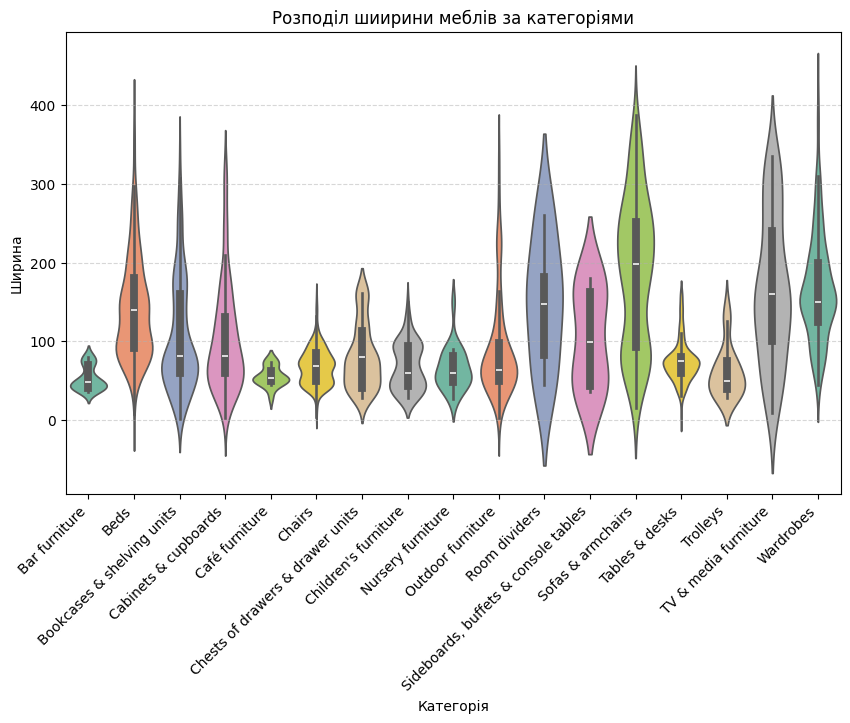

In [32]:
sns.violinplot(data=data_unique, x='category', y='width', hue='category', palette="Set2", legend=False)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel("Категорія")
plt.ylabel("Ширина")
plt.title("Розподіл шиирини меблів за категоріями")
plt.show()

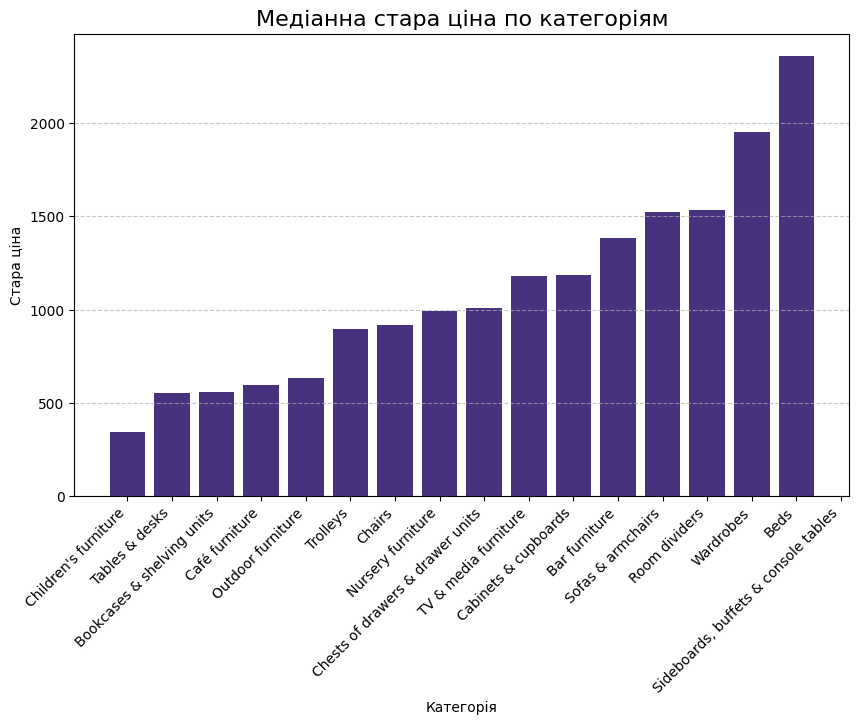

In [33]:
category_prices = data_unique.groupby('category')['old_price_clean'].median().sort_values()

plt.bar(category_prices.index, category_prices.values)
plt.title('Медіанна стара ціна по категоріям', fontsize=16)
plt.xlabel('Категорія')
plt.ylabel('Стара ціна')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

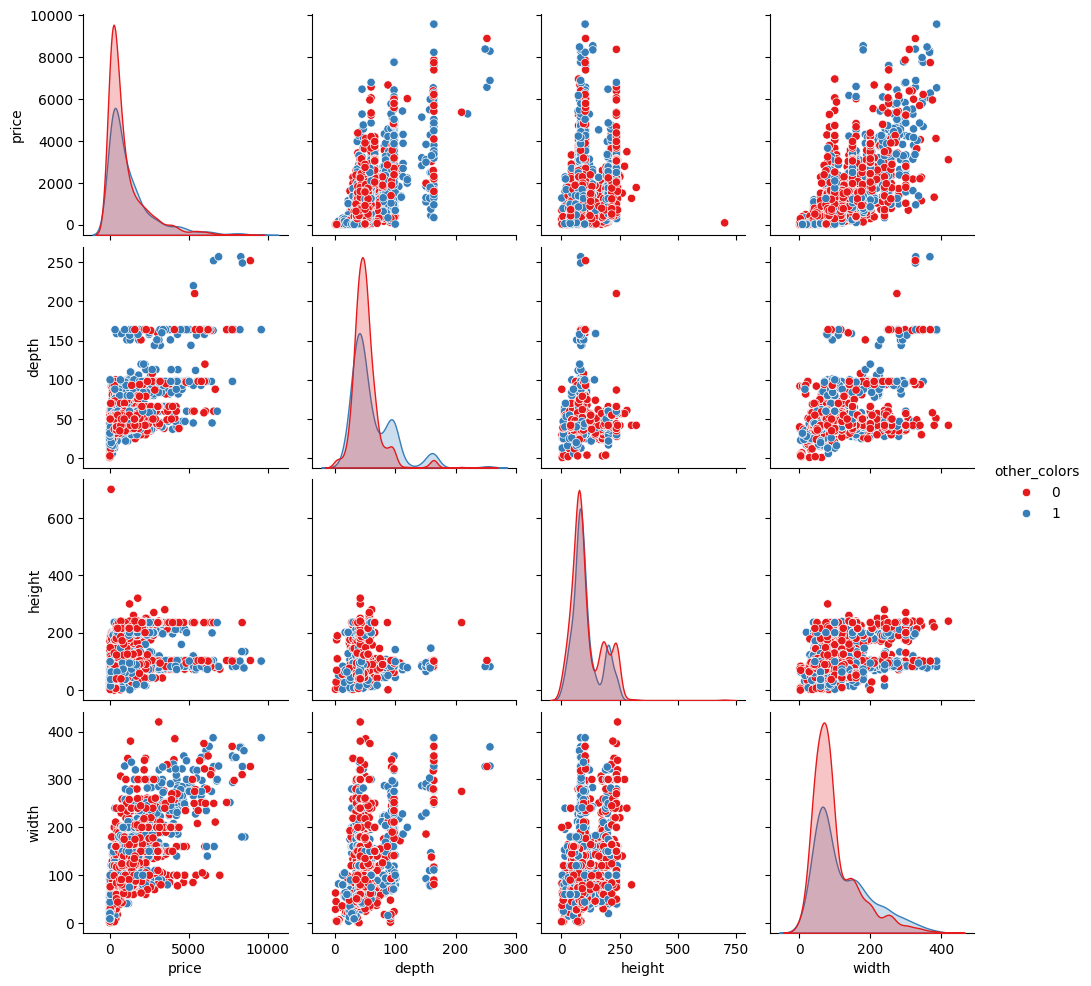

In [34]:
sns.pairplot(data_unique[['price', 'depth', 'height', 'width', 'other_colors', 'category']], hue = 'other_colors', palette='Set1')
plt.show()

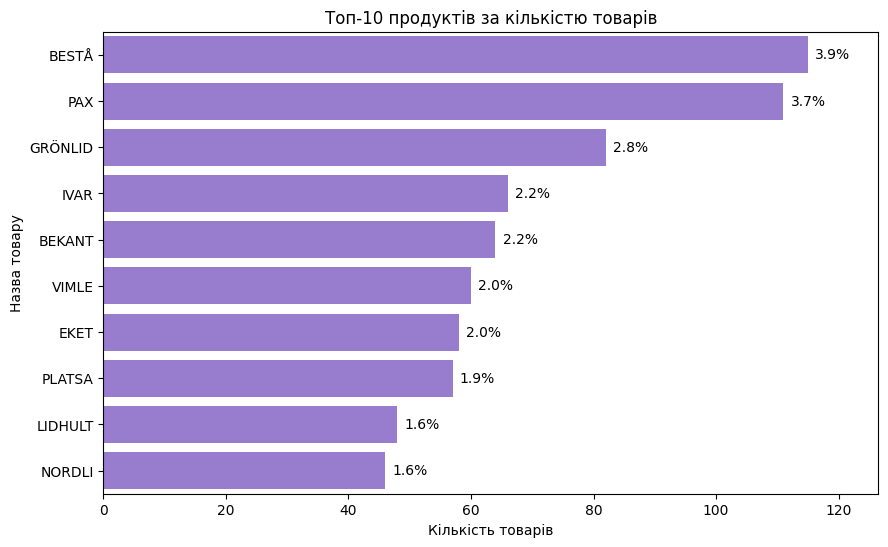

In [35]:
name_counts = data_unique['name'].value_counts().reset_index()
name_counts.columns = ['name', 'count']
top_10_products = name_counts.head(10).copy()

total_count = name_counts['count'].sum()

top_10_products['percentage'] = (top_10_products['count'] / total_count) * 100
max_count = top_10_products['count'].max()

sns.barplot(x='count', y='name', data=top_10_products, color='#9370DB')
for i, v in enumerate(top_10_products['count']):
    plt.text(v + max_count * 0.01, i, f"{top_10_products['percentage'].iloc[i]:.1f}%", va='center', ha='left')

plt.xlabel("Кількість товарів")
plt.ylabel("Назва товару")
plt.title("Топ-10 продуктів за кількістю товарів")
plt.xlim(0, max_count * 1.1)
plt.show()

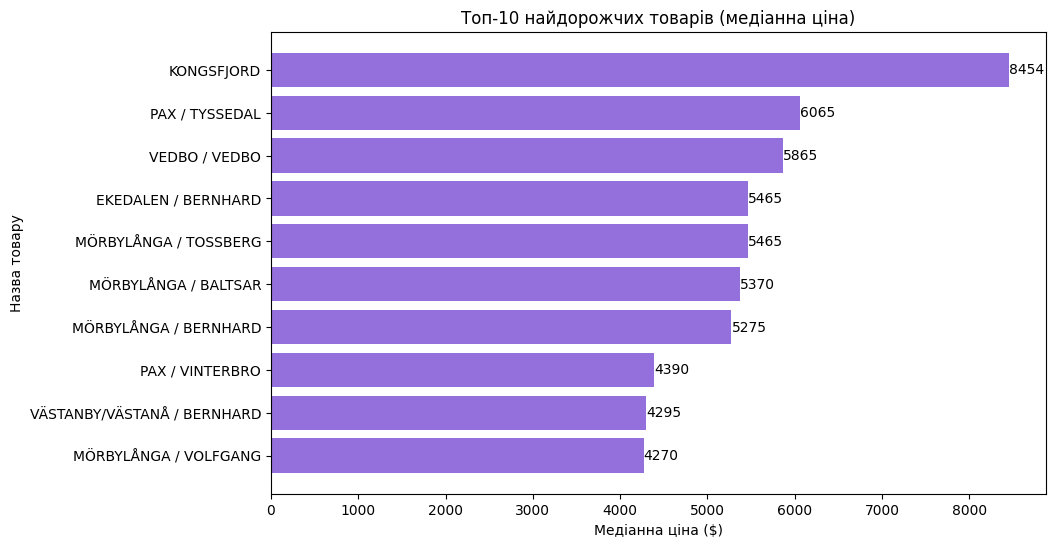

In [36]:
# Групуємо та обираємо ТОП-10 товарів за медіанною ціною
grouped = data_unique.groupby('name')['price'].median().reset_index()
top = grouped.sort_values('price', ascending=False).head(10).sort_values('price')

bars = plt.barh(top['name'], top['price'], color='#9370DB')
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
            f'{round(bar.get_width())}', ha='left', va='center', fontsize=10)

plt.xlabel("Медіанна ціна ($)")
plt.ylabel("Назва товару")
plt.title("Топ-10 найдорожчих товарів (медіанна ціна)")
plt.show()

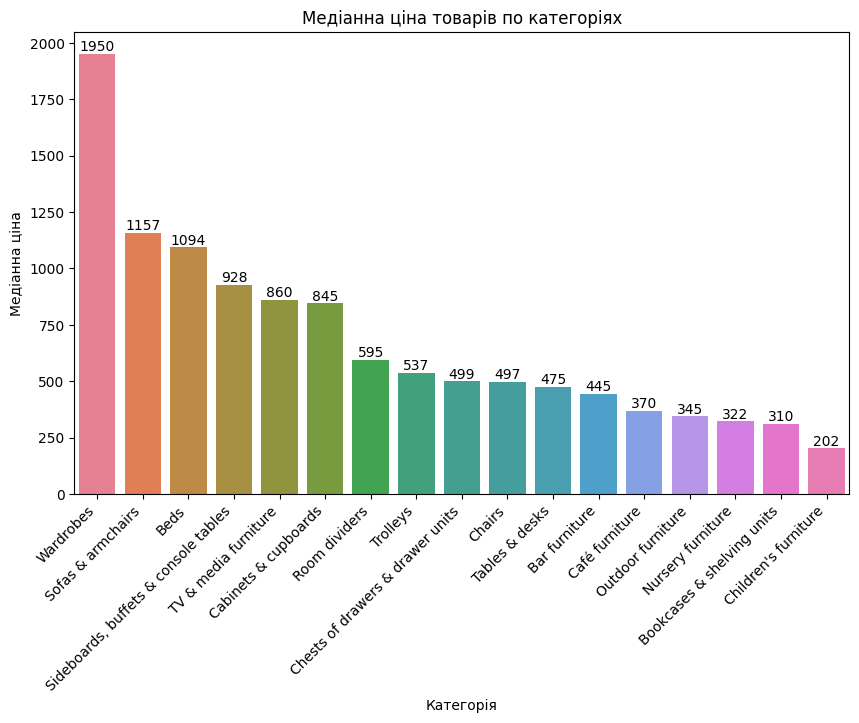

In [37]:
# Медіанна ціна товарів по категоріям по звичайній ціні
median_price_by_category = data_unique.groupby('category')['price'].median().reset_index()
median_price_by_category_sorted = median_price_by_category.sort_values('price', ascending=False)

bars = sns.barplot(x='category', y='price', data=median_price_by_category_sorted, hue='category')
for p in bars.patches:
    bars.annotate(f'{p.get_height():.0f}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  fontsize=10, color='black',
                  xytext=(0, 5), textcoords='offset points')

plt.title('Медіанна ціна товарів по категоріях')
plt.xlabel('Категорія')
plt.ylabel('Медіанна ціна')
plt.xticks(rotation=45, ha='right')
plt.show()

Найвища медіанна ціна у товарів з категорії шафи.

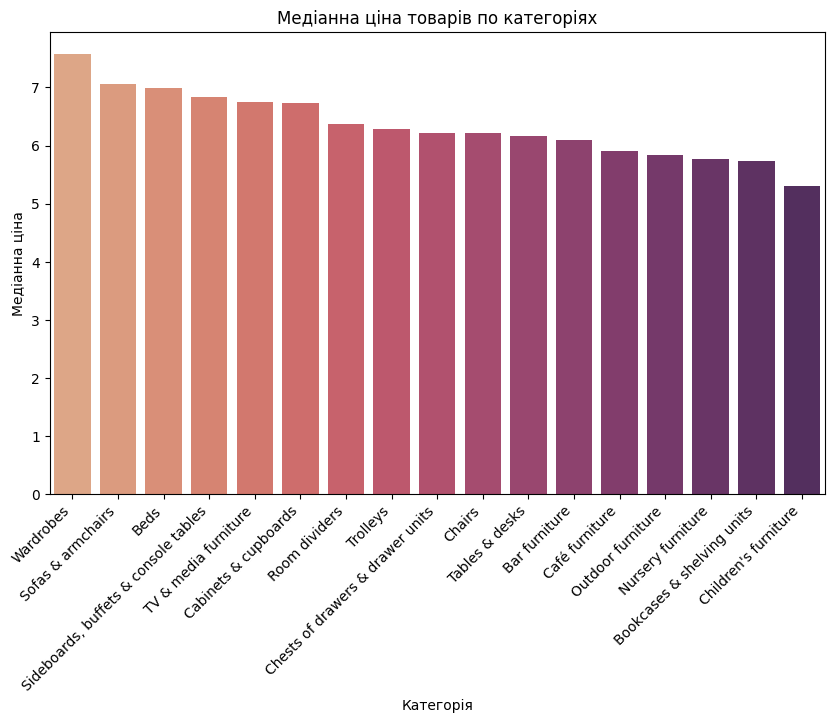

In [38]:
# Медіанна ціна товарів по категоріям (логарифмована ціна)
# Побудова даного графіку для логарифмованої ціни суттєво не відрізняється з графіком за звичайною ціною.
median_price_by_category = data_unique.groupby('category')['price_ln'].median().reset_index()
median_price_by_category_sorted = median_price_by_category.sort_values('price_ln', ascending=False)

sns.barplot(x='category', y='price_ln', data=median_price_by_category_sorted, hue='category', palette='flare')
plt.title('Медіанна ціна товарів по категоріях')
plt.xlabel('Категорія')
plt.ylabel('Медіанна ціна')
plt.xticks(rotation=45, ha='right')
plt.show()

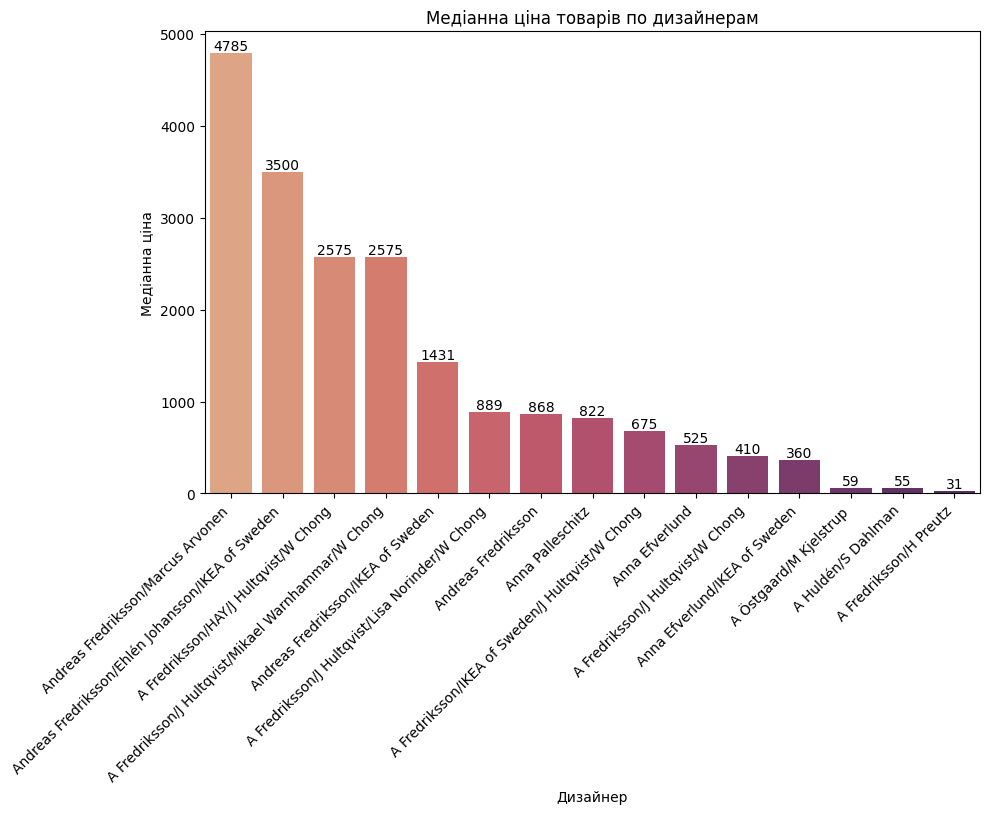

In [42]:
# Медіанна ціна товарів по дизайнерам (звичайна ціна)
median_price_by_designer_clean = data_unique.groupby('designer_clean')['price'].median().reset_index().head(15)
median_price_by_designer_clean_sorted = median_price_by_designer_clean.sort_values('price', ascending=False)

bars = sns.barplot(x='designer_clean', y='price', data=median_price_by_designer_clean_sorted, hue='designer_clean', palette='flare')
for p in bars.patches:
    bars.annotate(f'{p.get_height():.0f}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  fontsize=10, color='black',
                  xytext=(0, 5), textcoords='offset points')
plt.title('Медіанна ціна товарів по дизайнерам')
plt.xlabel('Дизайнер')
plt.ylabel('Медіанна ціна')
plt.xticks(rotation=45, ha='right')
plt.show()

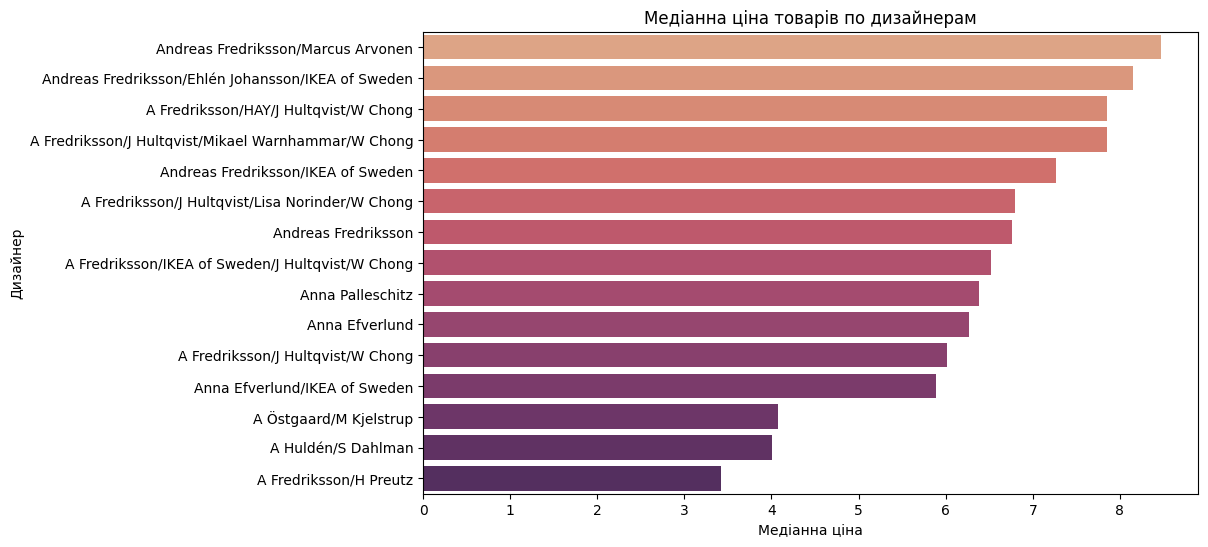

In [47]:
# Медіанна ціна товарів по дизайнерам (логарифмована ціна)
median_price_by_designer_clean = data_unique.groupby('designer_clean')['price_ln'].median().reset_index().head(15)
median_price_by_designer_clean_sorted = median_price_by_designer_clean.sort_values('price_ln', ascending=False)

sns.barplot(x='price_ln', y='designer_clean', data=median_price_by_designer_clean_sorted, hue='designer_clean', palette='flare')
plt.title('Медіанна ціна товарів по дизайнерам')
plt.xlabel('Медіанна ціна')
plt.ylabel('Дизайнер')
plt.show()

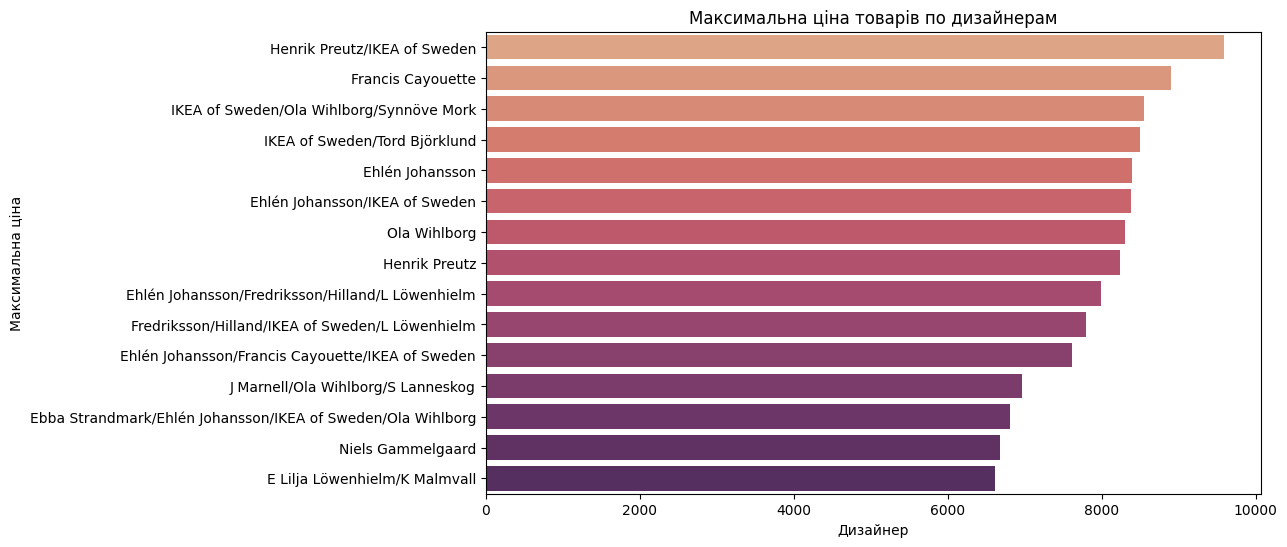

In [43]:
# Максимальна ціна товарів по дизайнерам
median_price_by_category = data_unique.groupby('designer_clean')['price'].max().reset_index()
median_price_by_category_sorted = median_price_by_category.sort_values('price', ascending=False).head(15)

sns.barplot(x='price', y='designer_clean', data=median_price_by_category_sorted, hue='designer_clean', palette='flare')
plt.title('Максимальна ціна товарів по дизайнерам')
plt.xlabel('Дизайнер')
plt.ylabel('Максимальна ціна')
plt.show()

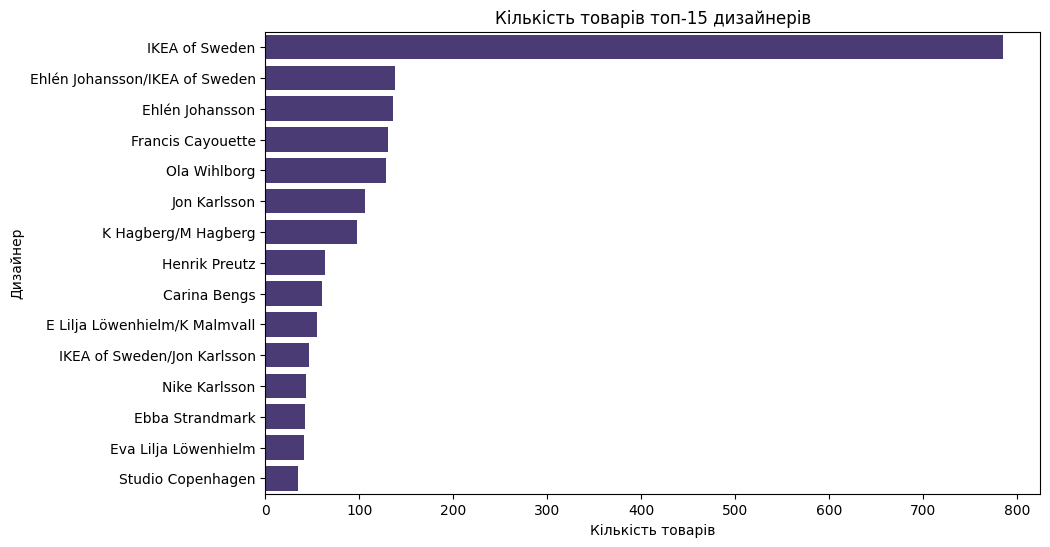

In [48]:
top_15_designers = data_unique['designer_clean'].value_counts().head(15).index

sns.countplot(
    data=data_unique[data_unique['designer_clean'].isin(top_15_designers)],
    y="designer_clean",
    order=top_15_designers
)
plt.title("Кількість товарів топ-15 дизайнерів")
plt.xlabel("Кількість товарів")
plt.ylabel("Дизайнер")
plt.show()

In [49]:
import plotly.express as px

# Групування за дизайнером і категорією
median_price_by_designer_category = data_unique.groupby(['designer_clean', 'category'])['price_ln'].median().reset_index()
max_price_ln = median_price_by_designer_category['price_ln'].max()
median_price_by_designer_category['price_percent'] = (median_price_by_designer_category['price_ln'] / max_price_ln) * 100

# Топ-15 дизайнерів за медіанною ціною
top_designers = median_price_by_designer_category.groupby('designer_clean')['price_ln'].median().nlargest(15).index
filtered_data = median_price_by_designer_category[median_price_by_designer_category['designer_clean'].isin(top_designers)]

fig = px.bar(
    filtered_data,
    x="price_percent",
    y="designer_clean",
    color="category",
    text="price_percent",
    title="Медіанна ціна за категоріями всередині дизайнерів (% від макс)",
    labels={"price_percent": "Медіанна ціна (% від макс)", "designer_clean": "Дизайнер", "category": "Категорія"},
    barmode="stack")

fig.update_traces(texttemplate='%{text:.2f}%', textposition='inside')

fig.update_layout(
    xaxis_tickangle=-45,
    title_x=0.5,
    title_font_size=18,
    legend_title='Категорія',
    template="plotly_white",
    xaxis=dict(showticklabels=False))
fig.show()

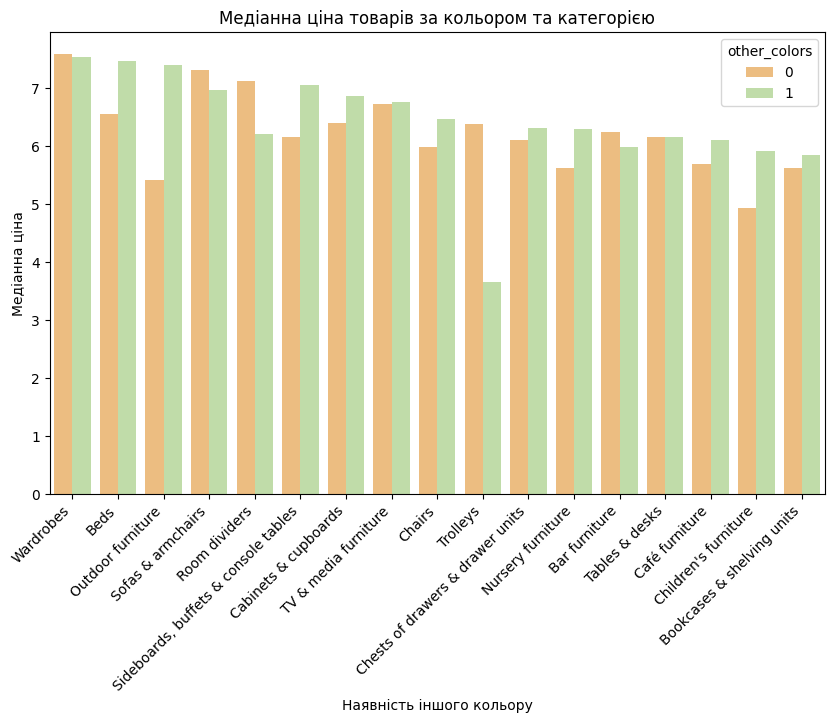

In [50]:
median_price_by_color_category = data_unique.groupby(['other_colors', 'category'])['price_ln'].median().reset_index()
median_price_by_color_category_sorted = median_price_by_color_category.sort_values('price_ln', ascending=False)

ax = sns.barplot(x='category', y='price_ln', data=median_price_by_color_category_sorted, hue='other_colors', palette='Spectral')
plt.title('Медіанна ціна товарів за кольором та категорією')
plt.xlabel('Наявність іншого кольору')
plt.ylabel('Медіанна ціна')
plt.xticks(rotation=45, ha='right')
plt.show()

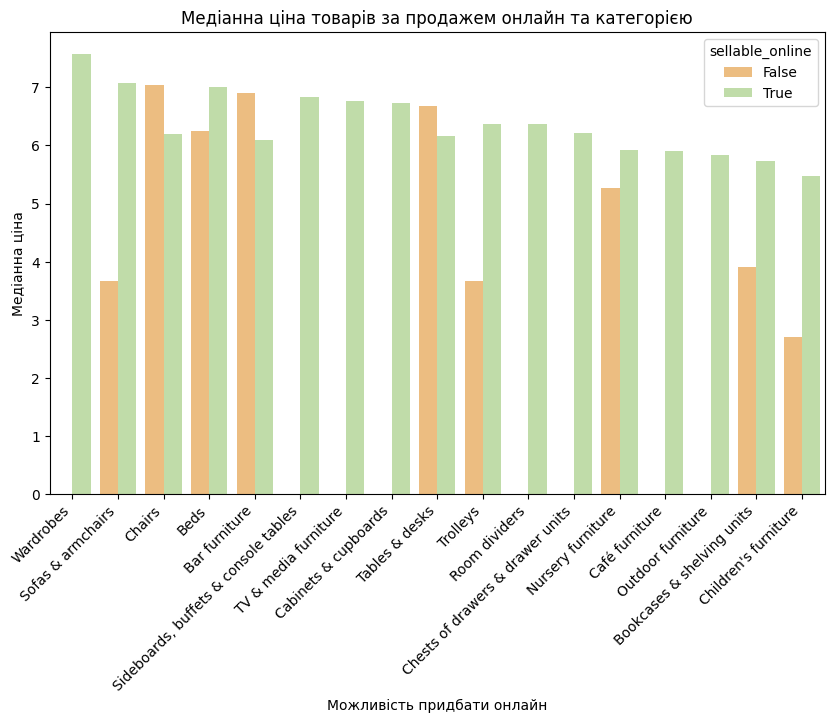

In [51]:
median_price_by_onlne_category = data_unique.groupby(['sellable_online', 'category'])['price_ln'].median().reset_index()
median_price_by_online_category_sorted = median_price_by_onlne_category.sort_values('price_ln', ascending=False)

ax = sns.barplot(x='category', y='price_ln', data=median_price_by_online_category_sorted, hue='sellable_online', palette='Spectral')
plt.title('Медіанна ціна товарів за продажем онлайн та категорією')
plt.xlabel('Можливість придбати онлайн')
plt.ylabel('Медіанна ціна')
plt.xticks(rotation=45, ha='right')
plt.show()

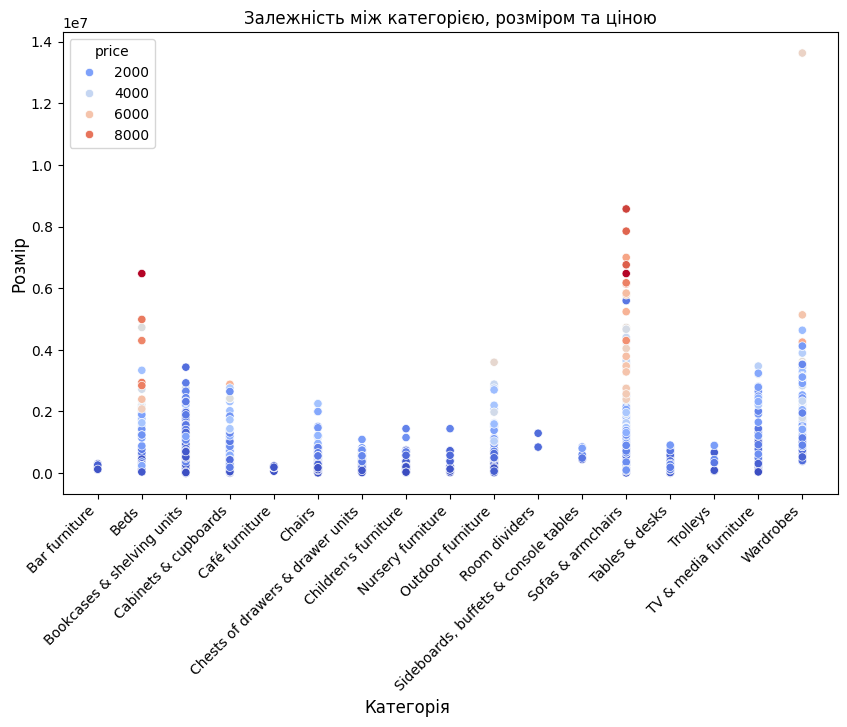

In [52]:
sns.scatterplot(x='category', y='size', hue="price", data=data_unique, palette='coolwarm')
plt.title("Залежність між категорією, розміром та ціною")
plt.xlabel("Категорія", fontsize=12, ha='right')
plt.ylabel("Розмір", fontsize=12, va='top', labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(ha='right')
plt.show()

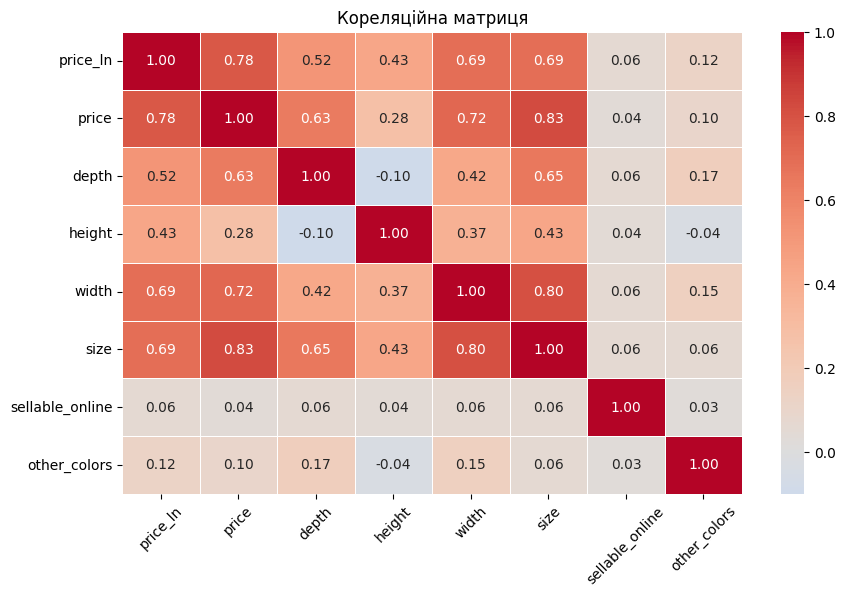

In [53]:
data_unique['sellable_online'] = data_unique['sellable_online'].astype(int)
numeric_cols = ['price_ln', 'price', 'depth', 'height', 'width', 'size', 'sellable_online', 'other_colors']

corr_matrix = data_unique[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)

plt.title("Кореляційна матриця")
plt.xticks(rotation=45)
plt.show()

Результати EDA:
Дані містили дублікати по item_id та пропущені значення по висоті/глибині/ширині.
Розподіл ціни лого нормальний з правостороннім нахилом, що враховано при подальшій обробці та використано логарифмування ціни.
За матрицею кореляцій спостерігається зв'язок вплив розміру товару (а саме ширини) на ціну.
Кількість товарів, які не продаються онлайн дуже мала, тому дана колонка для подальшого аналізу не буде використовуватись. Визначено медіанні ціни за дизайнерами та категоріями.

2. Перевірка гіпотез

'Кореляція між довжиною назви та ціною:'

,name_length,price_ln
name_length,1.000000,0.146691
price_ln,0.146691,1.000000


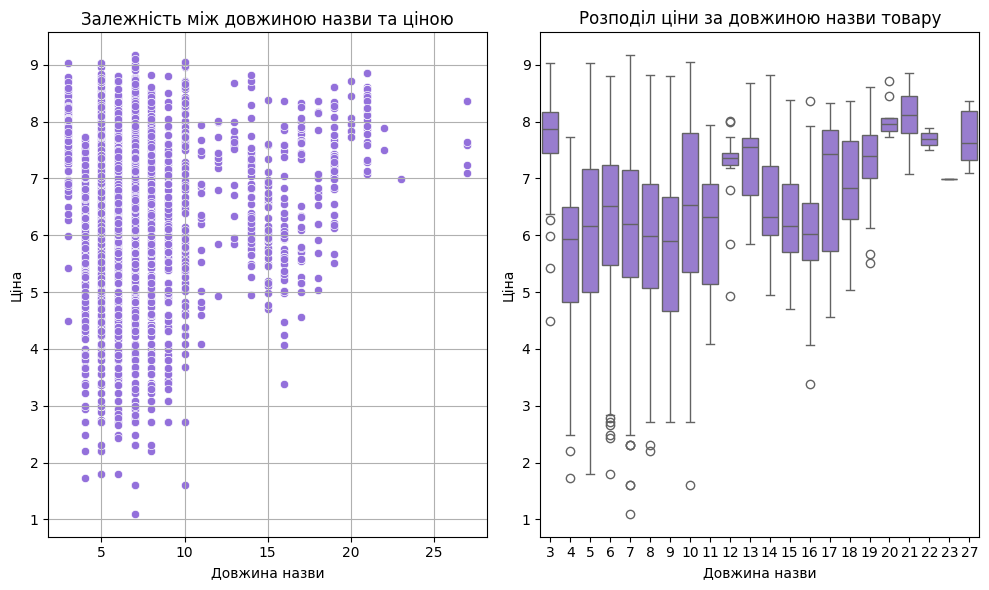

In [54]:
# Гіпотеза № 1: Товари з довшими назвами коштують дорожче. Чи IKEA використовує складніші назви для преміальних товарів?
#Нульова гіпотеза: немає залежності між довжиною тексту в колонці name та ціною товару.
#Альтернативна гіпотеза: товари з більшою довжиною тексту в колонці name мають вищу ціну

# Додавання стовпця з довжиною назви товару
data_unique['name_length'] = data_unique['name'].apply(len)

# 1) Кореляція Пірсона
correlation = data_unique[['name_length', 'price_ln']].corr()
display("Кореляція між довжиною назви та ціною:", correlation)

plt.subplot(1, 2, 1)
sns.scatterplot(x='name_length', y='price_ln', data=data_unique, color='#9370DB')
plt.title("Залежність між довжиною назви та ціною")
plt.xlabel("Довжина назви")
plt.ylabel("Ціна")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='name_length', y='price_ln', data=data_unique, color='#9370DB')
plt.title("Розподіл ціни за довжиною назви товару")
plt.xlabel("Довжина назви")
plt.ylabel("Ціна")
plt.tight_layout()
plt.show()

Існує слабкий позитивний зв'язок між довжиною назви товару та його ціною. Однак, цей зв'язок є досить слабким, оскільки кореляція близька до 0. Інші фактори значно більше впливають на ціну товару, а не тільки його назва.

In [55]:
# 2) Побудова лінійної регресійної моделі
X = data_unique[['name_length']]
y = data_unique['price_ln']

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               price_ln   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     65.09
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.03e-15
Time:                        11:45:12   Log-Likelihood:                -5244.2
No. Observations:                2962   AIC:                         1.049e+04
Df Residuals:                    2960   BIC:                         1.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.7851      0.059     98.365      

Оскільки коефіцієнт позитивний і значущий (p-value < 0.05), можемо відхилити нульову гіпотезу та сказати, що довжина назви має слабкий, але позитивний вплив на ціну. Проте низьке R-squared означає, що довжина назви — не єдиний фактор, що впливає на ціну.

In [56]:
# 3) t-test порівняння середніх цін для двох груп
data_unique['name_length'] = data_unique['name'].apply(len)
median_name_length = data_unique['name_length'].median()
short_name_category = data_unique[data_unique['name_length'] <= median_name_length]
long_name_category = data_unique[data_unique['name_length'] > median_name_length]

t_statistic, p_value = ttest_ind(short_name_category['price'], long_name_category['price'], equal_var=False)

print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

# Обчислення середніх цін для кожної групи
short_name_mean = np.mean(short_name_category['price'])
long_name_mean = np.mean(long_name_category['price'])
difference_means = long_name_mean - short_name_mean

if p_value < 0.05:
    if difference_means > 0:
        print('Товари з довшими назвами коштують дорожче.')
    else:
        print('Товари з коротшими назвами коштують дорожче.')
else:
    print('Немає статистично значущої різниці між цінами товарів з короткими та довгими назвами.')

T-statistic: -1.17
P-value: 0.242
Немає статистично значущої різниці між цінами товарів з короткими та довгими назвами.


In [57]:
# 4) Mann-Whitney-Wilcoxon test
statistic, p_value = mannwhitneyu(short_name_category['price_ln'], long_name_category['price_ln'])

print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.3f}")

Statistic: 951567.50
P-value: 0.069


 p-value = 0.069, воно більше за 0.05, тому ми не можемо відкинути нульову гіпотезу і не можемо стверджувати, що між групами є значуща різниця. Однак, значення близьке до 0.05 може вказувати на певну тенденцію до різниці, але вона не є статистично значущою при стандартному рівні значущості 0.05

In [58]:
# 5) Bootstrap Test
n_bootstraps = 10000
diffs = np.empty(n_bootstraps)
for i in range(n_bootstraps):
    short_samples = np.random.choice(short_name_category['name_length'], size=len(short_name_category), replace=True)
    long_samples = np.random.choice(long_name_category['name_length'], size=len(long_name_category), replace=True)
    diffs[i] = np.mean(long_samples) - np.mean(short_samples)

# Обчислення p-value
p_value = np.sum(diffs >= 0) / n_bootstraps
print(f"P-value: {p_value:.3f}")

P-value: 1.000


P-value = 1.000 вказує на те, що різниця між середніми довжинами назв для двох груп (короткі та довгі назви) не є статистично значущою.
Це також означає, не можна відкинути нульову гіпотезу, і немає суттєвої різниці між довжинами назв для цих двох груп.

In [ ]:
# Гіпотеза № 2: Товари, які мають більше варіантів кольорів, коштують дорожче.
#Нульова гіпотеза: немає залежності у ціні товарів, які є в одному кольорі, та товарів з різними варінтами кольорів.
#Альтернативна гіпотеза: ціна товарів, які мають варіанти кольорів, мають вищу ціну

In [59]:
# 1) Кореляція Пірсона
correlation = data_unique[['other_colors', 'price_ln']].corr()
display("Кореляція між наявністю інших кольорів товару та ціною:", correlation)

'Кореляція між наявністю інших кольорів товару та ціною:'

,other_colors,price_ln
other_colors,1.0000,0.1246
price_ln,0.1246,1.0000


In [60]:
# 2) t-test порівняння середніх цін для двох груп

no_color_price = data_unique[data_unique['other_colors'] == 0]['price']
color_price = data_unique[data_unique['other_colors'] == 1]['price']

t_statistic, p_value = ttest_ind(no_color_price, color_price, equal_var=False)

print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

if p_value < 0.05:
    print("Є статистично значуща різниця в цінах між товарами без кольору та з кольором.")
else:
    print("Немає статистично значущої різниці в цінах між товарами без кольору та з кольором.")

T-statistic: -5.45
P-value: 0.000
Є статистично значуща різниця в цінах між товарами без кольору та з кольором.


In [61]:
# 3) Mann-Whitney-Wilcoxon test
statistic, p_value = mannwhitneyu(no_color_price, color_price)

print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.3f}")

Statistic: 930008.50
P-value: 0.000


Відкидаємо нульову гіпотезу. Є статистично значуща різниця між цінами товарів без кольору та з кольором

In [62]:
# 4) Kruskal-Wallis test
statistic, p_value = kruskal(no_color_price, color_price)

print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))

Test statistic: 44.57
P-value: 0.0000


Результат тесту Крускала-Уолліса статистика: 44.57, р_значення:0.0000, що відхиляє нульову гіпотезу і підтверджує альтернативну.

In [63]:
# 5) ANOVA test - analysis of variance
_, p_value = stats.f_oneway(no_color_price, color_price)

alpha = 0.05

if p_value < alpha:
    print("Відкидаємо нульову гіпотезу. Є статистично значуща різниця в середній ціні меблів між товарами без кольору та з кольором.")
else:
    print("Нульову гіпотезу не відкидаємо. Статистично значущої різниці в середній ціні меблів між товарами без кольору та з кольором немає.")

Відкидаємо нульову гіпотезу. Є статистично значуща різниця в середній ціні меблів між товарами без кольору та з кольором.


In [64]:
# 6) Tukey's honestly significant difference (HSD) test

# Фільтрація цін для товарів без кольору (0) та з кольором (1)
no_color_price_values = data_unique[data_unique['other_colors'] == 0]['price'].values
color_price_values = data_unique[data_unique['other_colors'] == 1]['price'].values

# Об'єднуємо ціни та мітки для груп
prices = np.concatenate([no_color_price_values, color_price_values])
groups = np.concatenate([['no_color'] * len(no_color_price_values), ['color'] * len(color_price_values)])

tukey_results = pairwise_tukeyhsd(prices, groups)

print(tukey_results.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1  group2   meandiff p-adj   lower     upper   reject
----------------------------------------------------------
 color no_color -284.3111   0.0 -384.7826 -183.8395   True
----------------------------------------------------------


Між товарами з кольором та без кольору є статистично значуща різниця в цінах. Товари без кольору коштують на 284.31 одиниці дорожче, ніж товари з кольором, при рівні значущості 0.05. Цей тест підтверджує існування різниці між групами за середніми цінами.

In [65]:
# 7) Shuffle test

observed_diff = np.mean(no_color_price) - np.mean(color_price)

# Об'єднуємо ціни для пермутацій
concatenated_prices = np.concatenate([no_color_price, color_price])

n_permutations = 1000

# Масив для зберігання пермутаційних різниць
null_distribution = np.zeros(n_permutations)

# Виконуємо пермутації
for i in range(n_permutations):
  np.random.shuffle(concatenated_prices)
  shuffled_no_color_price = concatenated_prices[:len(no_color_price)]
  shuffled_color_price = concatenated_prices[len(no_color_price):]
  null_distribution[i] = np.mean(shuffled_no_color_price) - np.mean(shuffled_color_price)

p_value = np.mean(np.abs(null_distribution) >= np.abs(observed_diff))

print("Спостережувана різниця в середніх цінах: {:.2f}".format(observed_diff))
print("P-value: {:.4f}".format(p_value))

if p_value < 0.05:
    print("Відкидаємо нульову гіпотезу: існує статистично значуща різниця між цінами товарів без кольору та з кольором.")
else:
    print("Не можемо відкинути нульову гіпотезу: різниці між цінами товарів без кольору та з кольором немає.")

Спостережувана різниця в середніх цінах: -284.31
P-value: 0.0000
Відкидаємо нульову гіпотезу: існує статистично значуща різниця між цінами товарів без кольору та з кольором.


In [66]:
median_price_category = data_unique.groupby(['category'])['price'].median()
median_price_designer = data_unique.groupby(['designer_clean'])['price'].median()

# Додаємо медіану для дизайнерів за відповідністю значень у колонці
data_unique['designer_median_price'] = data_unique['designer_clean'].map(median_price_designer)

# Додаємо медіану для категорій за відповідністю значень у колонці
data_unique['category_median_price'] = data_unique['category'].map(median_price_category)

In [67]:
median_d = data_unique.groupby('category')['depth'].transform('median')
median_h = data_unique.groupby('category')['height'].transform('median')
median_w = data_unique.groupby('category')['width'].transform('median')

data_unique['depth_1'] = data_unique['depth'].fillna(median_d)
data_unique['height_1'] = data_unique['height'].fillna(median_h)
data_unique['width_1'] = data_unique['width'].fillna(median_w)

In [68]:
data_unique['category_median_price'] = data_unique['category_median_price'].fillna(data_unique['category_median_price'].median())
data_unique['designer_median_price'] = data_unique['designer_median_price'].fillna(data_unique['designer_median_price'].median())
print(data_unique[['category_median_price', 'designer_median_price']].isna().sum())

category_median_price    0
designer_median_price    0
dtype: int64


In [94]:
# Pipeline
#розіб'ємо даніна 80% для навчання, 20% для тестування.
#кількісні дані заповнимо медіаною категоріальні дані -заповнимо найбільш зустрічаємими використаємо модель DecisionTreeRegressor

X = data_unique[['depth', 'width', 'height', 'category_median_price', 'designer_median_price', 'other_colors','name']]
y = data_unique['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('impute', SimpleImputer(strategy='median'))
])

categorical_transf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

col_prepr = ColumnTransformer(transformers=[
    ('numeric', numeric_transf, ['depth', 'width', 'height', 'other_colors', 'category_median_price', 'designer_median_price']),
    ('categorical', categorical_transf, ['name'])
])

dtr = Pipeline(steps=[
    ('col_prep', col_prepr),
    ('dtr', DecisionTreeRegressor(max_depth=10, random_state=42))
])

dtr.fit(X_train, y_train)
dtr_predict = dtr.predict(X_test)

print('\nResults of DecisionTreeRegressor')
print('R^2 : {:.5f}'.format(r2_score(y_test, dtr_predict)))
print('MAE : {:.5f}'.format(mean_absolute_error(y_test, dtr_predict)))
print('MSE : {:.5f}'.format(np.sqrt(mean_squared_error(y_test, dtr_predict))))
print('Feature importance:')
print('--------------------------------')

for feat, importance in zip(X_train.columns, dtr.named_steps['dtr'].feature_importances_):
    print('{:.5f}    {}'.format(importance, feat))


Results of DecisionTreeRegressor
R^2 : 0.77307
MAE : 401.89031
MSE : 653.77172
Feature importance:
--------------------------------
0.09797    depth
0.52866    width
0.02313    height
0.00823    category_median_price
0.01385    designer_median_price
0.26732    other_colors
0.00000    name


In [91]:
#Функція для порівняння моделей
def getBestRegressor (X, Y):
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
    models = [
        sklearn.linear_model.LinearRegression(),
        sklearn.linear_model.LassoCV(),
        sklearn.linear_model.RidgeCV(),
        sklearn.svm.SVR(kernel='linear'),
        sklearn.neighbors.KNeighborsRegressor(n_neighbors=16),
        sklearn.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]

    TestModels = pd.DataFrame()
    res = {}
    tmp = {}

    for model in models:
        m = str(model)
        tmp['Model'] = m[:m.index('(')]
        model.fit(X_train, Y_train)
        tmp['R^2'] = '{:.5f}'.format(model.score(X_test, Y_test))
        tmp['MAE'] = '{:.5f}'.format(sklearn.metrics.mean_absolute_error(model.predict(X_test), Y_test))
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sklearn.metrics.mean_squared_error(model.predict(X_test), Y_test)))

        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])

    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['Y_train'] = Y_train
    res['X_test'] = X_test
    res['Y_test'] = Y_test
    return res

In [93]:
X1 = data_unique[['depth_1', 'width_1', 'height_1', 'category_median_price', 'designer_median_price', 'other_colors']]
Y1 = data_unique['price']

test1 = getBestRegressor(X1, Y1)
test1['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.81429,346.71953,591.42637
GradientBoostingRegressor,0.78394,398.97738,637.92007
DecisionTreeRegressor,0.73404,422.64848,707.76814
KNeighborsRegressor,0.67845,477.50886,778.22677
SVR,0.66697,503.84661,792.00331
LinearRegression,0.65885,541.31204,801.59311
RidgeCV,0.65878,541.30596,801.67756
LassoCV,0.65791,536.77654,802.69934


In [99]:
#Застосуємо GridSearchCV для RandomForestRegressor та налаштуємо гіперпараметри

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X1, Y1, test_size=0.2, random_state=42)
forest_grid = GridSearchCV(RandomForestRegressor(), {'n_estimators': [10, 30, 60, 100, 130, 160, 200],
                                                     'max_depth': [10, 30, 50, 70, 100, 120, 150, 180, 200],
                                                     'max_features': ['sqrt','log2']}, cv=5, n_jobs=-1, verbose=0)
forest_grid.fit(X_train, Y_train)

print('Best Estimator :',forest_grid.best_estimator_)
print('Best Score     :',forest_grid.best_score_)
print('')
print('R^2            : {:.5f}'.format(sklearn.metrics.r2_score(Y_test, forest_grid.predict(X_test))))
print('MAE            : {:.5f}'.format(sklearn.metrics.mean_absolute_error(forest_grid.predict(X_test), Y_test)))
print('RMSE           : {:.5f}'.format(np.sqrt(sklearn.metrics.mean_squared_error(forest_grid.predict(X_test), Y_test))))
print('')
print('Feature importance:')
print('--------------------------------')

for feat, importance in zip(X_train.columns, forest_grid.best_estimator_.feature_importances_):
    print('{:.5f}    {f}'.format(importance, f=feat))

Best Estimator : RandomForestRegressor(max_depth=180, max_features='sqrt', n_estimators=160)
Best Score     : 0.8303214009562074

R^2            : 0.82940
MAE            : 342.07478
RMSE           : 566.86280

Feature importance:
--------------------------------
0.13977    depth_1
0.38738    width_1
0.08452    height_1
0.06853    category_median_price
0.30316    designer_median_price
0.01664    other_colors


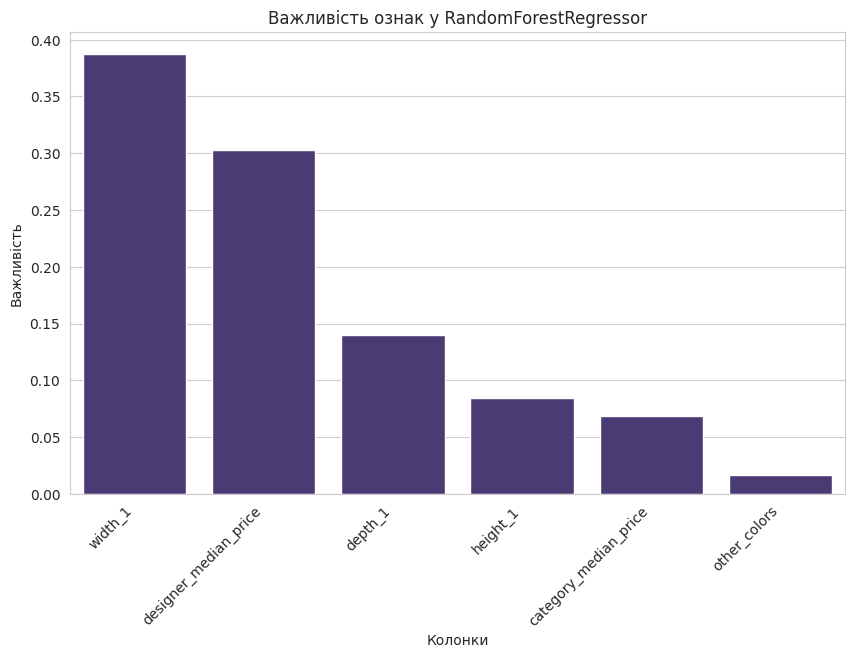

In [101]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': forest_grid.best_estimator_.feature_importances_
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

sns.set_style('whitegrid')
sns.barplot(x=feature_importance['Feature'], y=feature_importance['Importance'])

plt.xlabel("Колонки")
plt.ylabel("Важливість")
plt.title("Важливість ознак у RandomForestRegressor")
plt.xticks(rotation=45, ha='right')
plt.show()

RMSE: 562.76
MSE: 318000.42


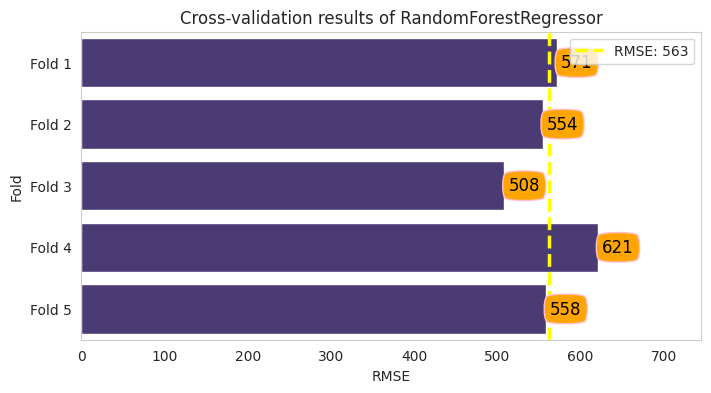

In [102]:
# Крос-валідація:

cv_rf_regression = KFold(n_splits=5, shuffle=True, random_state=42)

model_rf = Pipeline(steps=[
    ('preprocessor', col_prepr),
    ('rf_regressor', RandomForestRegressor(n_estimators=160, max_depth=180, random_state=42, n_jobs=-1))
])

cv_results = cross_validate(model_rf,
                            X, y,
                            cv=cv_rf_regression,
                            scoring=['neg_mean_squared_error'],
                            return_train_score=True)


mse_scores_rf_regression = -cv_results['test_neg_mean_squared_error']
rmse_scores_rf_regression = np.sqrt(mse_scores_rf_regression)
rmse_mean_rf_regression = rmse_scores_rf_regression.mean()

print(f'RMSE: {rmse_mean_rf_regression:.2f}')
print(f'MSE: {mse_scores_rf_regression.mean():.2f}')

fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(y=[f'Fold {i+1}' for i in range(len(rmse_scores_rf_regression))],
            x=rmse_scores_rf_regression,
            ax=ax)

# Додаємо вертикальну лінію середнього RMSE
ax.axvline(rmse_mean_rf_regression, color='yellow', linestyle='dashed', linewidth=2.5,
           label=f"RMSE: {round(rmse_mean_rf_regression)}")


for i, v in enumerate(rmse_scores_rf_regression):
    ax.text(v + 5, i, f"{round(v)}", ha='left', va='center', fontsize=12, color="black",
            bbox=dict(facecolor='orange', edgecolor='pink', boxstyle='round4,pad=0.4'))

ax.set_xlim(0, 1.2 * rmse_scores_rf_regression.max())

ax.set_xlabel('RMSE')
ax.set_ylabel('Fold')
ax.set_title('Cross-validation results of RandomForestRegressor')
ax.legend(loc='upper right')
ax.grid(False)
plt.show()